In [1]:
import numpy as np
import os
import pandas as pd
import phik
import seaborn as sns
from matplotlib import pyplot as plt 

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV

import plotly.express as px

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/advanced-dls-spring-2021/submission.csv
/kaggle/input/advanced-dls-spring-2021/train.csv
/kaggle/input/advanced-dls-spring-2021/test.csv


In [2]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

/bin/bash: gdown: command not found
/bin/bash: gdown: command not found
/bin/bash: gdown: command not found


In [3]:
data = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')

In [4]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = ['Churn']

In [5]:
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
3417,27,59.45,1611.65,Male,0,No,No,Yes,Yes,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Electronic check,0
2590,11,53.80,651.55,Female,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),0
4006,13,94.10,1215.6,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,No,Electronic check,1
3944,19,48.95,955.6,Male,0,Yes,Yes,Yes,No,DSL,Yes,No,No,No,No,No,One year,Yes,Bank transfer (automatic),0
3791,72,110.15,7881.2,Female,0,Yes,No,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

TotalSpent имеет тип object, хотя в примере значения flaot64; Что уже намекает на проблему.

In [7]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Нет пропусков

In [8]:
data.duplicated().sum()

14

Дупликатов 14 из 5282 объектов. Дропаем их, т.к. не много.

In [9]:
data.drop_duplicates(inplace=True)
data.shape

(5268, 20)

In [10]:
# Для числовых признаков проверим неявные пропуски:
for num_col in num_cols:
    print(num_col + ': ' + str(pd.to_numeric(data[num_col], errors='coerce').isna().sum()))

# Проблема наблюдается только в TotalSpent

ClientPeriod: 0
MonthlySpending: 0
TotalSpent: 9


In [11]:
data[pd.to_numeric(data[num_col], errors='coerce').isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [12]:
# ClientPeriod в строках с таким пропуском равен 0. Заменим эти пропуски на 0, имея ввиду, что 0 на старте по определению.

data['TotalSpent'] = data['TotalSpent'].replace(' ', '0').astype('float')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5268 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5268 non-null   int64  
 1   MonthlySpending           5268 non-null   float64
 2   TotalSpent                5268 non-null   float64
 3   Sex                       5268 non-null   object 
 4   IsSeniorCitizen           5268 non-null   int64  
 5   HasPartner                5268 non-null   object 
 6   HasChild                  5268 non-null   object 
 7   HasPhoneService           5268 non-null   object 
 8   HasMultiplePhoneNumbers   5268 non-null   object 
 9   HasInternetService        5268 non-null   object 
 10  HasOnlineSecurityService  5268 non-null   object 
 11  HasOnlineBackup           5268 non-null   object 
 12  HasDeviceProtection       5268 non-null   object 
 13  HasTechSupportAccess      5268 non-null   object 
 14  HasOnlineTV  

In [13]:
# Проделаем аналогичные преобразования для тетовой выборки

test['TotalSpent'] = test['TotalSpent'].replace(' ', '0').astype('float')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   float64
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

### Анализ данных

1) Для численных призанков постройте гистограмму (plt.hist(...)) или boxplot (plt.boxplot(...)). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать data.value_counts() и построить bar диаграммы plt.bar(...) или круговые диаграммы plt.pie(...) (хорошо, елси вы сможете это сделать на одном гарфике с помощью plt.subplots(...)).

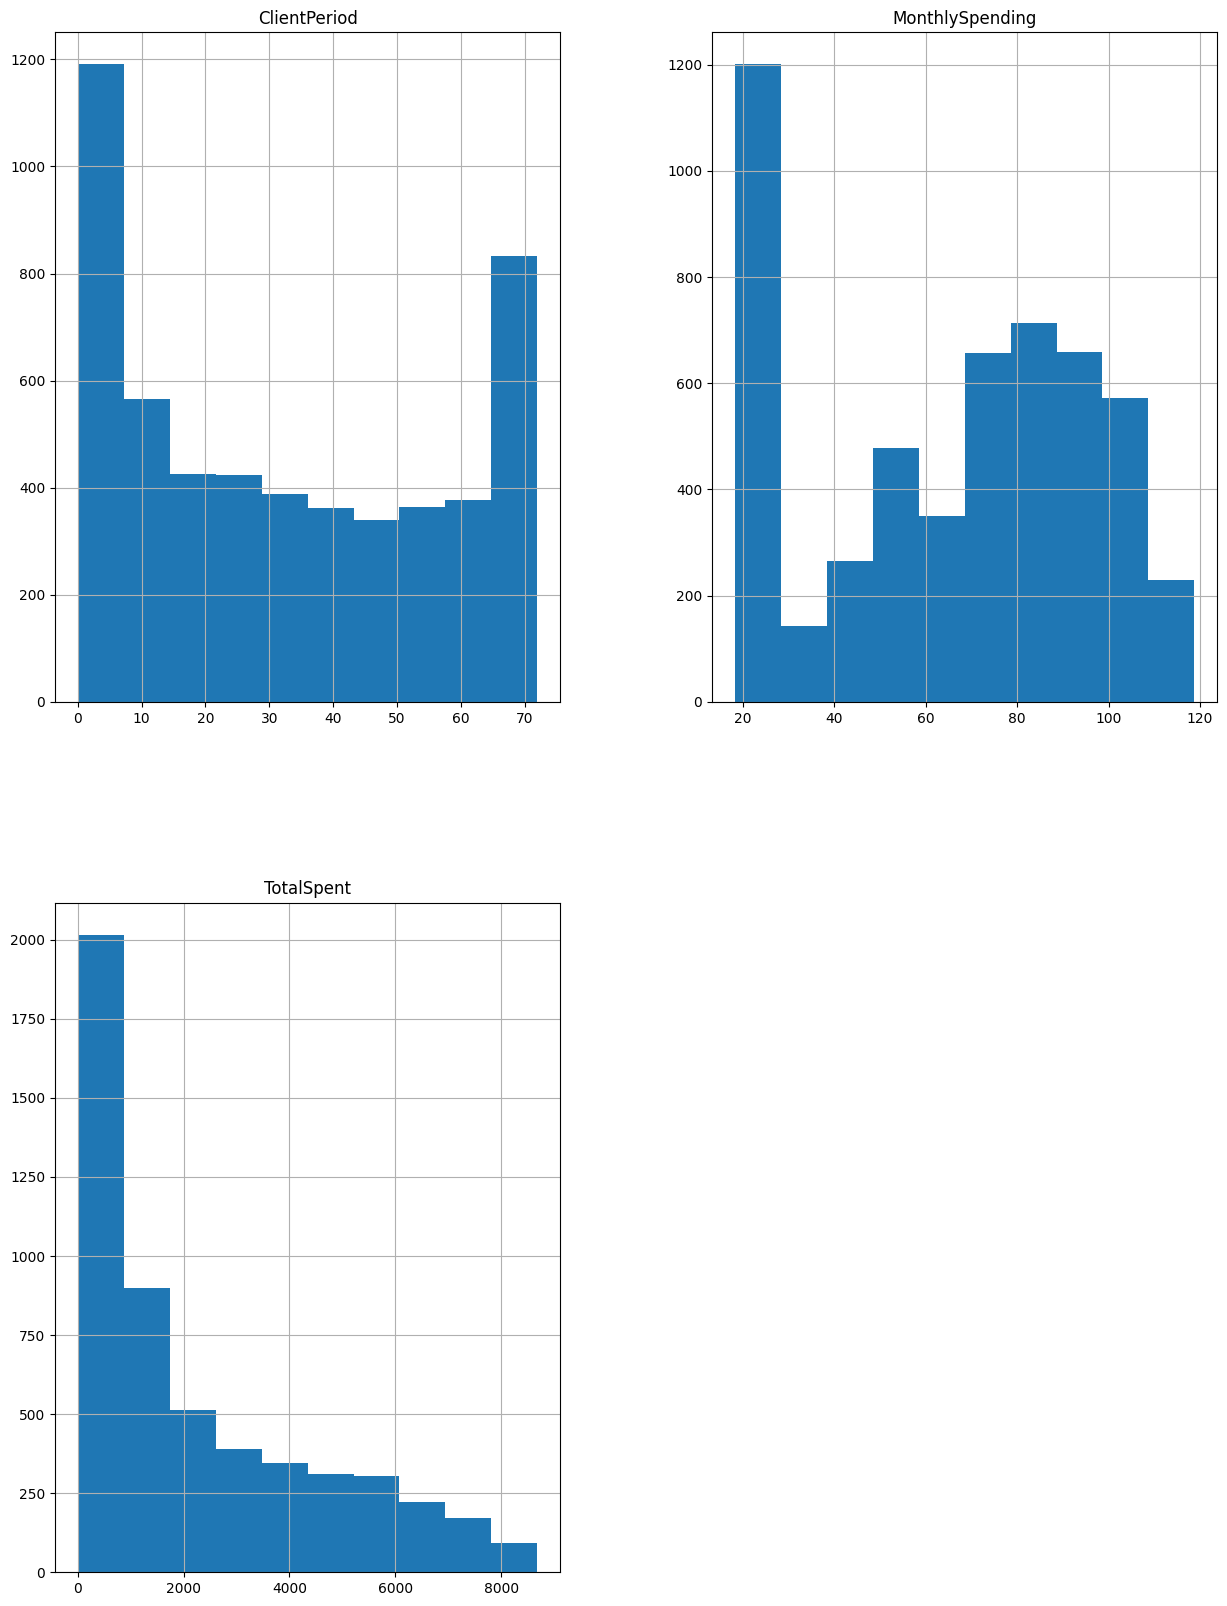

In [14]:
data[num_cols].hist(figsize=(15, 20))
None

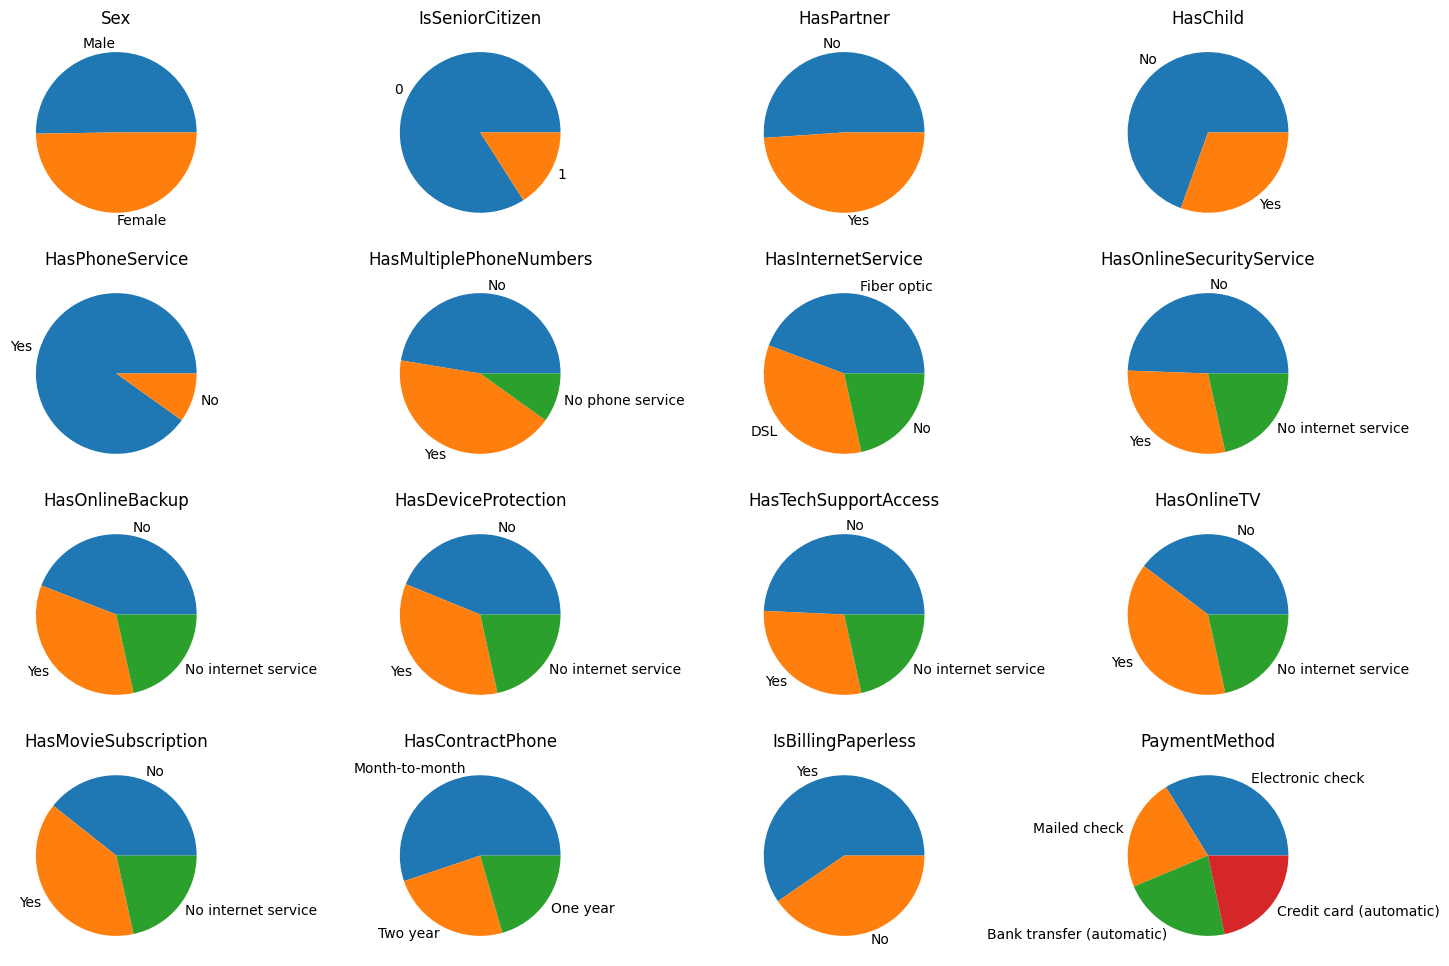

In [15]:
fig, axes = plt.subplots(4, 4, figsize=(18, 12))

for ax, cat_col in zip(axes.flatten(), cat_cols):
    ax.set_title(cat_col)
    counts = data[cat_col].value_counts()
    labels = counts.index
    ax.pie(counts, labels=labels)

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

In [16]:
data.Churn.value_counts()

Churn
0    3894
1    1374
Name: count, dtype: int64

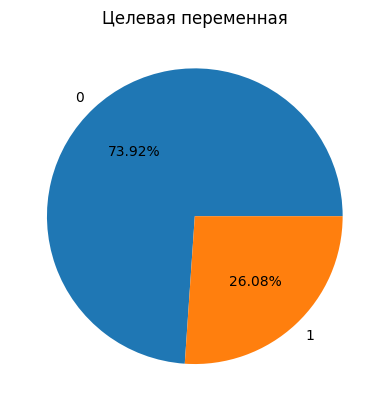

In [17]:
plt.pie(
    data.Churn.value_counts(),
    autopct='%.2f%%',
    labels=data.Churn.unique()
)
plt.title('Целевая переменная')
None

Вывод (пункт 2): классы являются несбалансированными, нельзя использовать метрику accuracy. Используем ROC-AUC.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - sns, pandas_visual_analysis, etc.

In [18]:
def get_hist(col):
    return px.histogram(
        data,
        x=col,
        title=col,
        marginal='box',
        color='Churn'
    )

In [19]:
get_hist('ClientPeriod').show()

Наблюдаем, что значительная часть клиентов уходит в самом начале пользования.

In [20]:
get_hist('MonthlySpending').show()

Ушедшие клиенты платили в месяц в среднем больше чем текущии. Медианны значения 79,6 против 64,8 соответственно.

In [21]:
get_hist('TotalSpent').show()

В целом, тут распределения похожи и среди текущих и среди ушедших клиентов: увеличение расходов уменьшает число клиентов.

interval columns not set, guessing: ['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'IsSeniorCitizen', 'Churn']


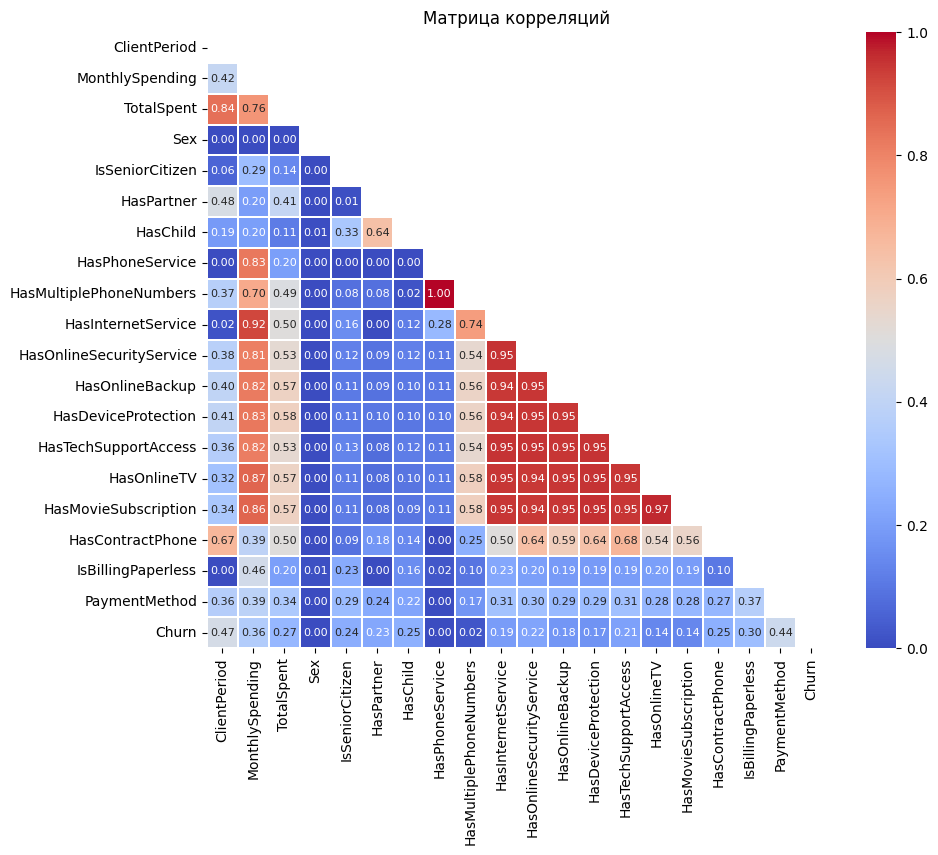

In [22]:
corr_data = data.phik_matrix()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_data, dtype=bool))
sns.heatmap(corr_data, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 8}, linewidths=0.2)

plt.title("Матрица корреляций")
plt.xticks(rotation=90)
plt.show()

- Видно, что есть категории описывающие наличие дополнительных сервисов, которые сильно корелирует между собой.
- Также они сильно коррелируют с MonthlySpending.

In [23]:
# remove = [
#     'HasMultiplePhoneNumbers',
#     'HasInternetService',
#     'HasOnlineBackup',
#     'HasDeviceProtection',
#     'HasTechSupportAccess',
#     'HasOnlineTV',
#     'HasMovieSubscription',
# ]
# data.drop(remove, axis=1, inplace=True)

# test.drop(remove, axis=1, inplace=True)

# [cat_cols.remove(x) for x in remove]
# feature_cols = cat_cols + num_cols

# Удаление части признаков дает худший результат на test'e ~= 0.848, против 0.853. Наверное, здесь можно перебрать варианты.

### Применение линейных моделей

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а.

In [24]:
X = data.drop(target_col, axis=1)
y = data.Churn

In [25]:
# Pipeline для Логистической регрессии

cat_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error')),
])

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols),
        ('num', num_transformer, num_cols),
    ])

regression_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', LogisticRegression())])

In [26]:
%%time
param_grid = {'model__C': [100, 10, 1, 0.1, 0.01, 0.001],
              'model__penalty': ['l1', 'l2'],
              'model__solver': ['liblinear', 'saga'],
              'model__max_iter': [500, 1000]}

regression_cv = RandomizedSearchCV(regression_pipe,
                                   param_grid, cv=5,
                                   scoring='roc_auc',
                                   n_iter=15, 
                                   random_state=42)

regression_cv.fit(X, y)

regression_cv.best_score_

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



CPU times: user 27.1 s, sys: 20.1 s, total: 47.2 s
Wall time: 23.7 s


0.8445719968902466

### Применение градиентного бустинга

-- использую кроссвалидацию - RandomizedSearchCV (пункт дополнительно в требованиях)


In [27]:
%%time

params = {
  'depth': [2, 3, 4, 5],
  'l2_leaf_reg': [0.1, 0.5, 1, 5, 10],
  'subsample': [0.5, 0.7],
  'n_estimators': [300, 500, 700, 1000],
  'learning_rate':[0.01, 0.05, 0.1, 0.3],
  'grow_policy': ['Lossguide']
}

catboost_cv = RandomizedSearchCV(estimator=CatBoostClassifier(
                                cat_features=cat_cols,
                                eval_metric="AUC:hints=skip_train~false",
                                verbose = 1000),
                                param_distributions=params, 
                                scoring='roc_auc',
                                cv=5,
                                n_iter=15, 
                                random_state=42)

catboost_cv.fit(X, y)

catboost_cv.best_score_

0:	learn: 0.7995325	total: 62.4ms	remaining: 31.1s
499:	learn: 0.9999721	total: 3.48s	remaining: 0us
0:	learn: 0.8051341	total: 7.85ms	remaining: 3.92s
499:	learn: 0.9999863	total: 3.35s	remaining: 0us
0:	learn: 0.7998761	total: 7.41ms	remaining: 3.7s
499:	learn: 0.9999647	total: 3.46s	remaining: 0us
0:	learn: 0.8032892	total: 6.76ms	remaining: 3.38s
499:	learn: 0.9999937	total: 3.5s	remaining: 0us
0:	learn: 0.8018047	total: 7.89ms	remaining: 3.94s
499:	learn: 0.9999953	total: 3.48s	remaining: 0us
0:	learn: 0.7416902	total: 4.9ms	remaining: 1.46s
299:	learn: 0.8695144	total: 1.23s	remaining: 0us
0:	learn: 0.7577554	total: 4.87ms	remaining: 1.46s
299:	learn: 0.8707329	total: 1.32s	remaining: 0us
0:	learn: 0.7328739	total: 5.74ms	remaining: 1.71s
299:	learn: 0.8728284	total: 1.28s	remaining: 0us
0:	learn: 0.7707766	total: 4.42ms	remaining: 1.32s
299:	learn: 0.8699427	total: 1.24s	remaining: 0us
0:	learn: 0.7659807	total: 4.61ms	remaining: 1.38s
299:	learn: 0.8707564	total: 1.24s	remainin

0.8480626108808126

In [28]:
# CatBoostClassifier CV показал лучший результат, чем LogisticRegression CV.
# Выберем его, в качестве лучшей модели и обучем на всей выборке.

best_model = CatBoostClassifier(**catboost_cv.best_params_, cat_features=cat_cols, verbose = 1000)
best_model.fit(X, y)

0:	learn: 0.6883857	total: 5.01ms	remaining: 5s
999:	learn: 0.3946360	total: 4.33s	remaining: 0us


In [29]:
submission = pd.Series(best_model.predict_proba(test)[:, 1])
submission = pd.DataFrame({
    'Id': range(len(submission)),
    'Churn': submission
    })

# запишем предсказания
submission.to_csv('submission.csv', index = False)